Install Julia if running on Google Colab

In [ ]:
%%capture
%%shell
wget -O - https://raw.githubusercontent.com/JuliaAI/Imbalance.jl/dev/docs/src/examples/colab.sh
"""
This should take around one minute to finish. Once it does, change the runtime to `Julia` by choosing `Runtime` 
from the toolbar then `Change runtime type`. You can then delete this cell.
"""

Install needed packages

In [ ]:
ENV["JULIA_PKG_SERVER"] = ""
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add(["DataFrames", "Plots", "Colors", "CategoricalArrays", "Random", 
         "Imbalance", "MLJBase", "TableTransforms", "ScientificTypes", "HTTP"])


using DataFrames
using Plots
using CategoricalArrays
using Random
using MLJBase: machine, transform
using TableTransforms
using Imbalance
using HTTP: download

### 1. Generate Random Data

In [2]:
rng = Random.default_rng()

type="ColTable"
num_rows = 300
num_features = 5
class_probs = [0.5, 0.2, 0.3]
y_ind = 3

Xy, _ = generate_imbalanced_data(num_rows, num_features; class_probs, type, insert_y=y_ind, rng=42)
X, y = generate_imbalanced_data(num_rows, num_features; class_probs, type, rng=42)

((Column1 = [0.564, 0.862, 0.793, 0.505, 1.213, 0.683, 0.699, 0.387, 0.334, 0.545  …  0.668, 0.576, 1.224, 0.817, 0.288, 1.269, 0.511, 0.612, 0.471, 0.653], Column2 = [0.927, 0.5, 0.484, 0.869, 1.338, 0.606, 0.717, 1.501, 1.55, 0.763  …  0.63, 0.325, 1.81, 0.558, 1.3, 1.649, 1.548, 0.988, 0.651, 0.555], Column3 = [0.633, 0.744, 0.672, 0.65, 0.575, 0.74, 0.609, 0.005, 0.055, 0.741  …  0.724, 0.654, 0.767, 0.708, 0.035, 0.155, 0.027, 0.634, 0.579, 0.672], Column4 = [0.125, 0.17, 0.217, 0.154, 0.222, 0.206, 0.264, 0.663, 0.663, 0.107  …  0.223, 0.318, 0.204, 0.254, 0.634, 0.31, 0.599, 0.175, 0.123, 0.08], Column5 = [0.49, 0.504, 0.829, 0.798, 1.454, 0.009, 0.514, 0.087, -0.034, -0.021  …  0.658, 0.089, 1.425, 0.478, -0.01, 1.456, 0.009, 0.067, -0.19, 1.059]), CategoricalValue{Int64, UInt32}[0, 0, 0, 0, 1, 0, 0, 2, 2, 0  …  0, 0, 1, 0, 2, 1, 2, 0, 0, 0])

### 2. Apply Cluster Undersampler

#### Using Imbalance Only

In [3]:
X_under, y_under = cluster_undersample(
	X,
	y;
	mode = "nearest",
	ratios = Dict(0 => 1.0, 1 => 1.0, 2 => 0.9),
	rng = 42,
)

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:02


((Column1 = [0.628, 0.708, 0.542, 0.633, 0.79, 0.674, 0.52, 0.726, 0.544, 0.748  …  0.492, 0.07, 0.311, 0.428, 0.379, 0.065, 0.184, 0.224, 0.777, 0.557], Column2 = [0.365, 0.65, 0.587, 0.508, 0.483, 0.877, 0.57, 0.079, 0.704, 0.617  …  1.667, 1.434, 1.725, 1.524, 1.404, 1.31, 1.508, 1.856, 1.581, 1.676], Column3 = [0.722, 0.658, 0.722, 0.725, 0.764, 0.734, 0.578, 0.75, 0.654, 0.711  …  0.047, 0.047, 0.035, 0.023, 0.024, 0.03, 0.049, 0.05, 0.044, 0.041], Column4 = [0.059, 0.134, 0.334, 0.129, 0.215, 0.314, 0.01, 0.232, 0.145, 0.256  …  0.918, 0.911, 0.672, 0.796, 0.864, 0.701, 0.778, 0.795, 0.712, 0.816], Column5 = [0.089, 0.308, 0.372, 0.959, 0.73, 0.089, 0.549, 0.558, 0.016, 0.797  …  0.134, 0.041, 0.062, 0.143, 0.148, -0.064, 0.116, 0.061, 0.17, 0.081]), CategoricalValue{Int64, UInt32}[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#### Using MLJ

In [4]:
naive_model = Imbalance.MLJ.ClusterUndersampler(
	mode = "nearest",
	ratios = Dict(0 => 1.0, 1 => 1.0, 2 => 0.9),
	maxiter = 50,
	rng = 42,
)
mach = machine(naive_model)
X_under, y_under = transform(mach, X, y)

((Column1 = [0.628, 0.708, 0.542, 0.633, 0.79, 0.674, 0.52, 0.726, 0.544, 0.748  …  0.492, 0.07, 0.311, 0.428, 0.379, 0.065, 0.184, 0.224, 0.777, 0.557], Column2 = [0.365, 0.65, 0.587, 0.508, 0.483, 0.877, 0.57, 0.079, 0.704, 0.617  …  1.667, 1.434, 1.725, 1.524, 1.404, 1.31, 1.508, 1.856, 1.581, 1.676], Column3 = [0.722, 0.658, 0.722, 0.725, 0.764, 0.734, 0.578, 0.75, 0.654, 0.711  …  0.047, 0.047, 0.035, 0.023, 0.024, 0.03, 0.049, 0.05, 0.044, 0.041], Column4 = [0.059, 0.134, 0.334, 0.129, 0.215, 0.314, 0.01, 0.232, 0.145, 0.256  …  0.918, 0.911, 0.672, 0.796, 0.864, 0.701, 0.778, 0.795, 0.712, 0.816], Column5 = [0.089, 0.308, 0.372, 0.959, 0.73, 0.089, 0.549, 0.558, 0.016, 0.797  …  0.134, 0.041, 0.062, 0.143, 0.148, -0.064, 0.116, 0.061, 0.17, 0.081]), CategoricalValue{Int64, UInt32}[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#### Using TableTransforms

In [5]:
using Imbalance: TableTransforms.ClusterUndersampler
model_t = ClusterUndersampler(
	y_ind,
	mode = "nearest",
	ratios = Dict(0 => 1.0, 1 => 0.9, 2 => 1.0),
	maxiter = 50,
	rng = 42,
)
Xyover = Xy |> model_t

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01



Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
  class:  2.0


(Column1 = [0.628, 0.708, 0.542, 0.633, 0.79, 0.674, 0.52, 0.726, 0.544, 0.748  …  0.428, 0.081, 0.272, 0.438, 0.038, 0.296, 0.09, 0.194, 0.401, 0.142],
 Column2 = [0.365, 0.65, 0.587, 0.508, 0.483, 0.877, 0.57, 0.079, 0.704, 0.617  …  1.577, 1.312, 1.493, 1.461, 1.758, 1.649, 1.622, 1.652, 1.487, 1.498],
 Column3 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0],
 Column4 = [0.722, 0.658, 0.722, 0.725, 0.764, 0.734, 0.578, 0.75, 0.654, 0.711  …  0.019, 0.041, 0.02, 0.032, 0.053, 0.019, 0.007, 0.051, 0.049, 0.021],
 Column5 = [0.059, 0.134, 0.334, 0.129, 0.215, 0.314, 0.01, 0.232, 0.145, 0.256  …  0.926, 0.549, 0.699, 0.712, 0.744, 0.899, 0.587, 0.568, 0.888, 0.974],
 Column6 = [0.089, 0.308, 0.372, 0.959, 0.73, 0.089, 0.549, 0.558, 0.016, 0.797  …  0.062, 0.106, 0.023, 0.067, -0.015, 0.043, 0.13, 0.038, -0.001, 0.052],)

### 3. Plot the Results

    Updating registry at `~/.julia/registries/General`


    Updating git-repo `https://github.com/JuliaRegistries/General.git`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Manifest.toml`


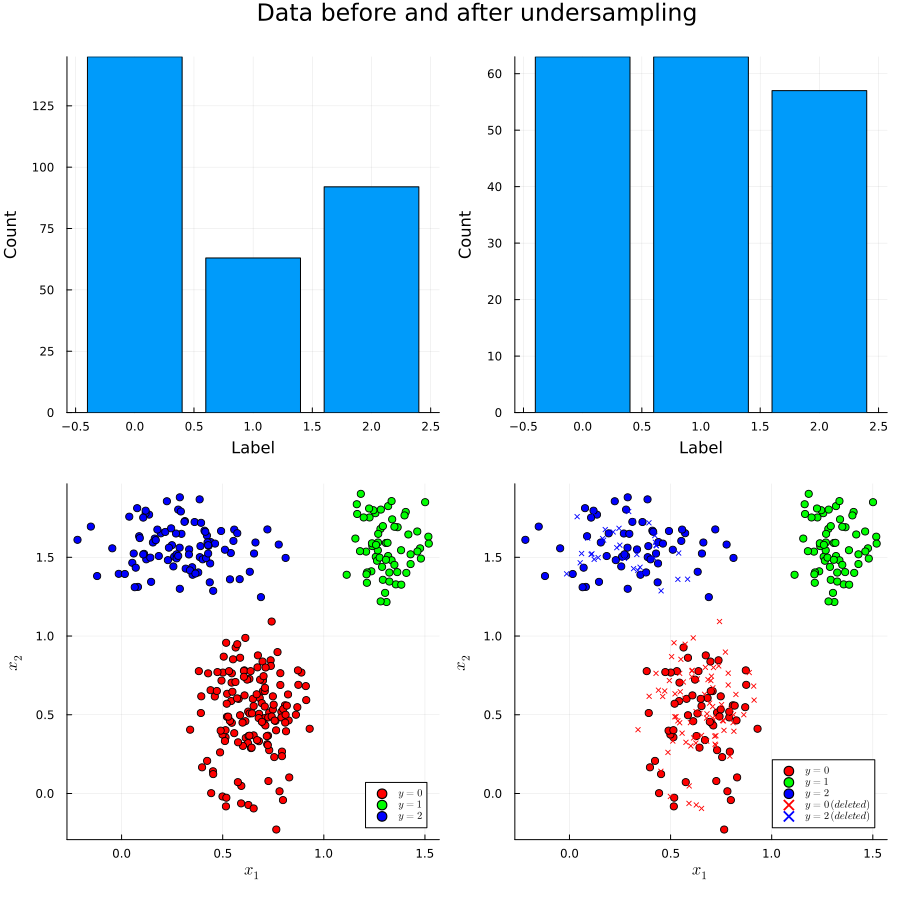

In [8]:
download("https://raw.githubusercontent.com/JuliaAI/Imbalance.jl/dev/examples/plot.jl", "./")
include("plot.jl")                      # provides a plot function to compare results
plot_data(y, y_under, X, X_under)

Plots.AnimatedGif("/Users/essam/Documents/GitHub/Imbalance.jl/examples/assets/cluster_undersample.gif")
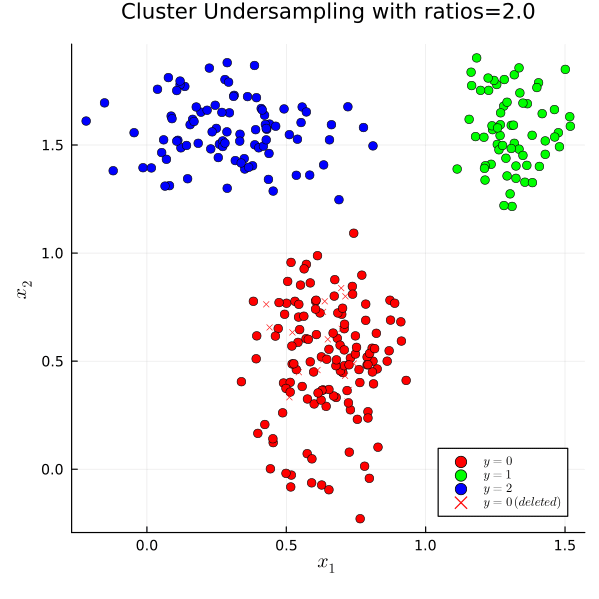

In [10]:
import Logging
Logging.disable_logging(Logging.Warn)

anim = @animate for ratios ∈ 2.0:-0.05:0.1
	X_under, y_under = cluster_undersample(X, y; ratios = ratios, rng = 42)
	plot_data(y, y_under, X, X_under; single_plot=true, 
			  single_plot_title="Cluster Undersampling with ratios=$ratios")
end
gif(anim, (isdir("./assets")) ? "./assets/cluster_undersample.gif" : "./cluster_undersample.gif", fps=3)